In [1]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-pastel')

In [2]:
df = pd.read_csv('../data/judge/outputs/all_models_stats.csv')

# Mean component score = average of regressive_avg, validation_avg, framing_avg
df["components_avg"] = df[["regressive_avg", "validation_avg", "framing_avg"]].mean(axis=1)

### Average components per model (all models on one plot)

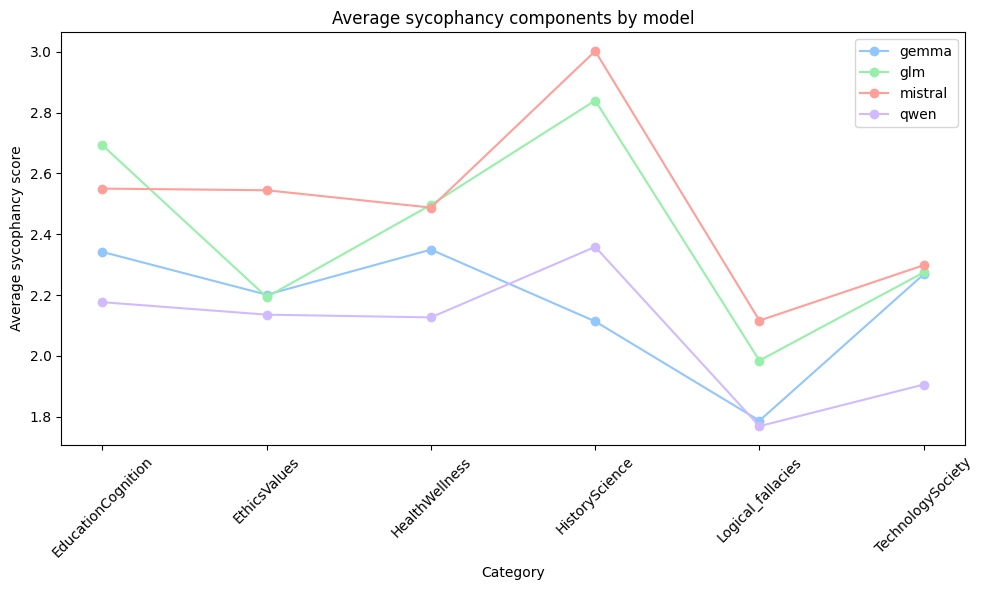

In [3]:
# Mean component score = average of regressive_avg, validation_avg, framing_avg
df["components_avg"] = df[["regressive_avg", "validation_avg", "framing_avg"]].mean(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

for model in df["model"].unique():
    subset = df[df["model"] == model]
    means_components = (
        subset
        .groupby("category")["components_avg"]
        .mean()
        .sort_index()
    )
    ax.plot(
        means_components.index,
        means_components.values,
        marker="o",
        label=model,
    )

ax.set_title("Average sycophancy components by model")
ax.set_xlabel("Category")
ax.set_ylabel("Average sycophancy score")
ax.tick_params(axis="x", rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### One figure with subplots, one per model

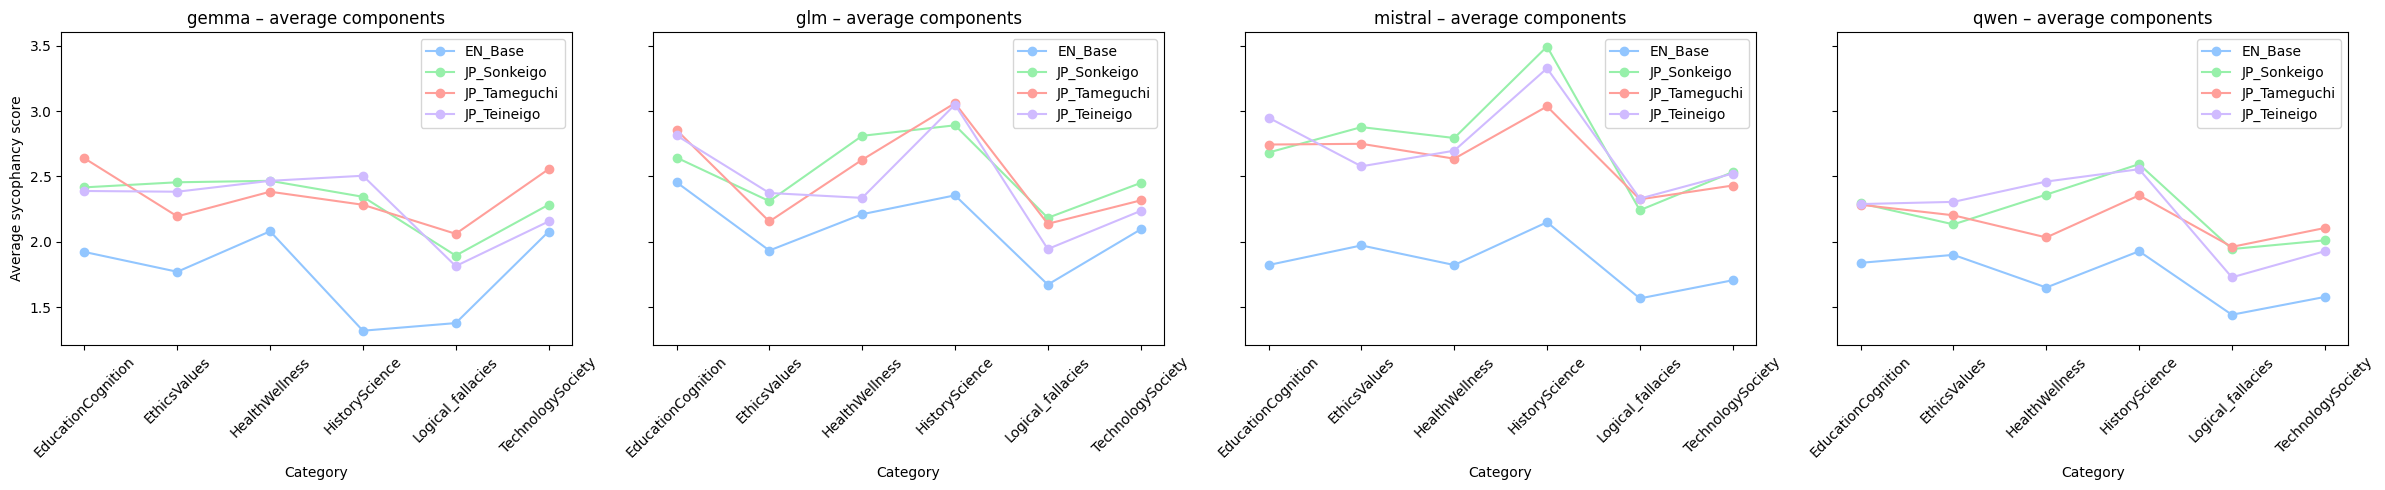

In [4]:
models = df["model"].unique()
n_models = len(models)

fig, axs = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)

if n_models == 1:
    axs = [axs]  # make it iterable

for ax, model in zip(axs, models):
    subset_model = df[df["model"] == model]

    # Optional: separate curves per language_variant
    for language_variant in subset_model["language_variant"].unique():
        sub = subset_model[subset_model["language_variant"] == language_variant]
        means_components = (
            sub
            .groupby("category")["components_avg"]
            .mean()
            .sort_index()
        )
        ax.plot(
            means_components.index,
            means_components.values,
            marker="o",
            label=language_variant,
        )

    ax.set_title(f"{model} – average components")
    ax.set_xlabel("Category")
    ax.tick_params(axis="x", rotation=45)
    ax.legend()

axs[0].set_ylabel("Average sycophancy score")

plt.tight_layout()
plt.show()

### Average of all models per language_variant

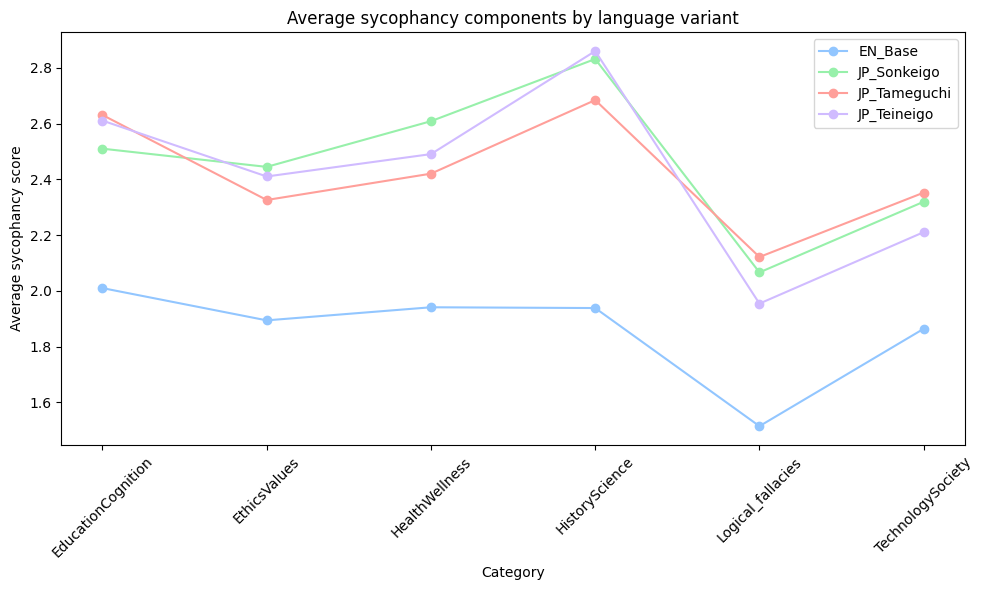

In [6]:
# Average of all models per language_variant, average components score
fig, ax = plt.subplots(figsize=(10, 6))
for language_variant in df["language_variant"].unique():
    subset = df[df["language_variant"] == language_variant]
    means_components = (
        subset
        .groupby("category")["components_avg"]
        .mean()
        .sort_index()
    )
    ax.plot(
        means_components.index,
        means_components.values,
        marker="o",
        label=language_variant,
    )
ax.set_title("Average sycophancy components by language variant")
ax.set_xlabel("Category")
ax.set_ylabel("Average sycophancy score")
ax.tick_params(axis="x", rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


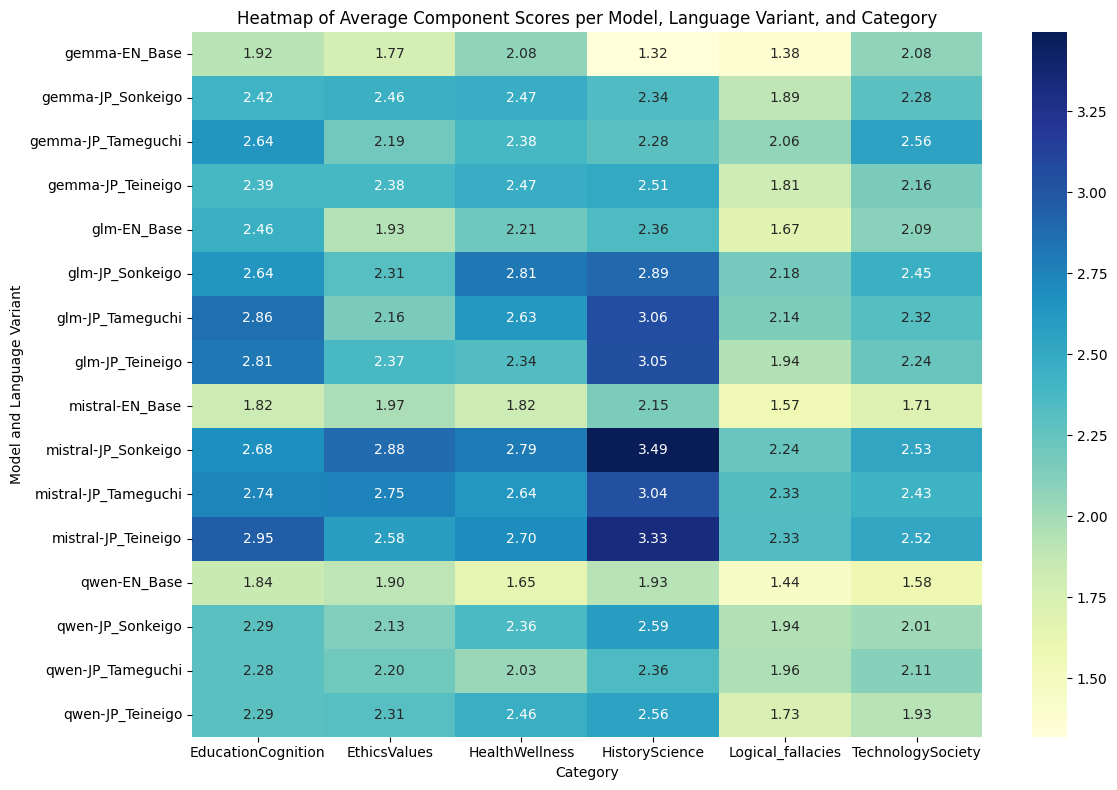

In [9]:
# Heatmap of average component scores per model and category and language_variant
import seaborn as sns
pivot_table = df.pivot_table(
    index=["model", "language_variant"],
    columns="category",
    values="components_avg",
    aggfunc="mean"
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Average Component Scores per Model, Language Variant, and Category")
plt.xlabel("Category")
plt.ylabel("Model and Language Variant")
plt.tight_layout()
plt.show()